# 1D harmonic oscillator using physics-informed neural network (PINN)

## Problem overview

1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$




In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def plot_result(x,y,x_data,y_data,yh,xlim_low,xlim_high,ylim_low,ylim_high,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=3, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(xlim_low, xlim_high)
    plt.ylim(ylim_low, ylim_high)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

In [3]:
class FCN(nn.Module):
    "Defines a connected network"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Generate training data

> use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$.

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


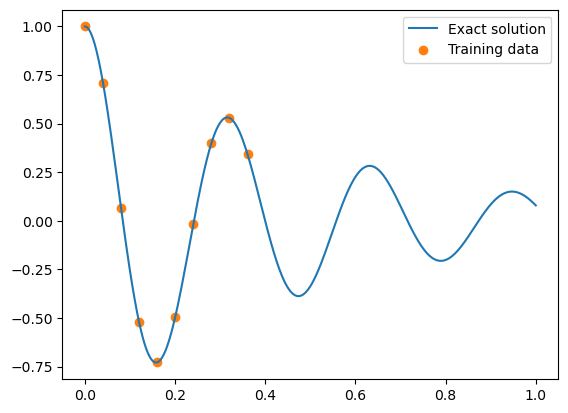

In [4]:
def oscillator(d, w0, x):
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

## PINN

>add the underlying differential equation ("physics loss") to the loss function.


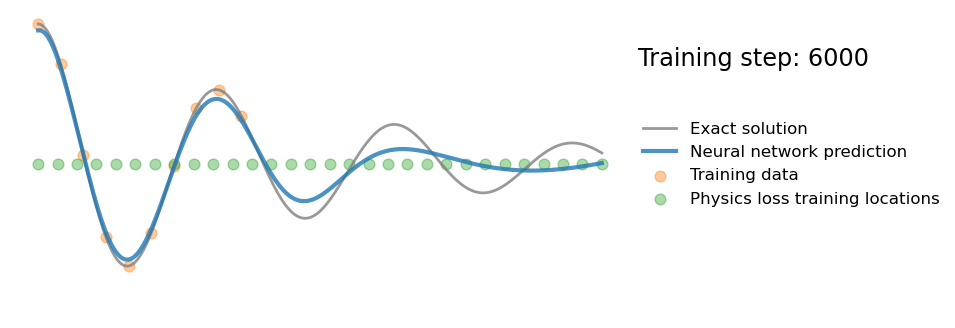

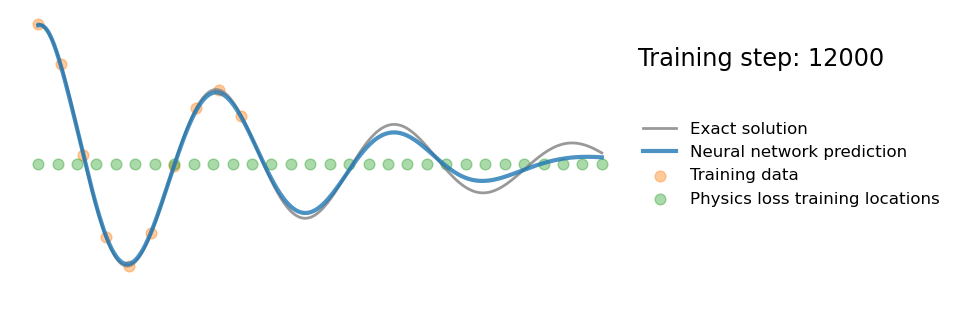

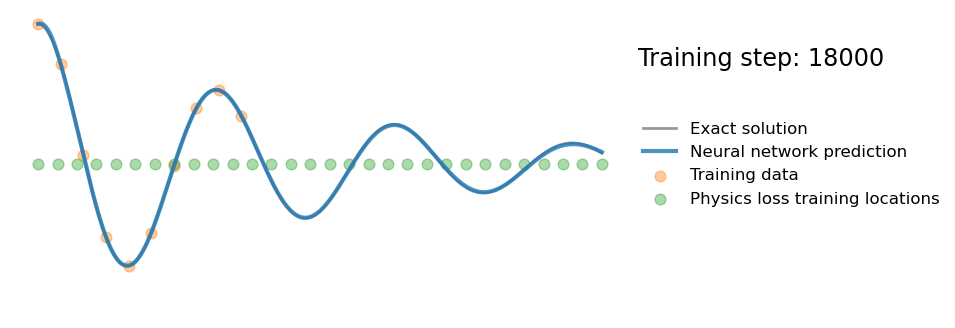

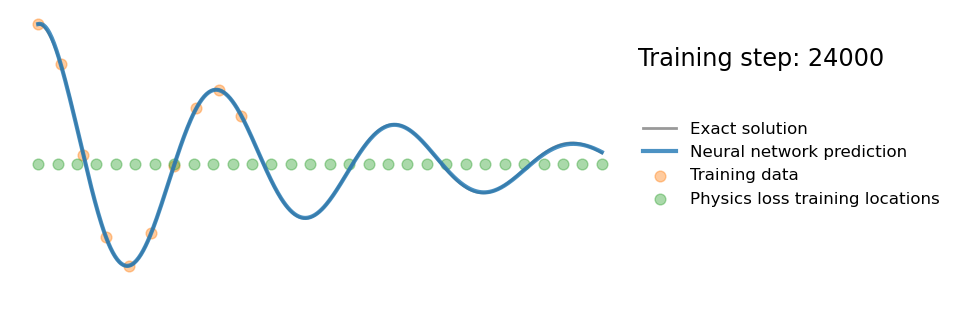

In [5]:
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True) # sample locations over the problem domain
mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
for i in range(24000):
    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error

    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp # computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)

    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()


    # plot the result as training progresses
    if (i+1) % 150 == 0:

        yh = model(x).detach()
        xp = x_physics.detach()
        xlim_low = -0.05
        xlim_high = 1.05
        ylim_low = -1.1
        ylim_high = 1.1
        plot_result(x,y,x_data,y_data,yh,xlim_low,xlim_high,ylim_low,ylim_high,xp)

        file = "chm_pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")

save_gif_PIL("chm_pinn.gif", files, fps=20, loop=0)

# 1D quantum harmonic oscillator using physics-informed neural network (PINN)

## Problem overview

The Hamiltonian for the quantum harmonic oscillator, which models a particle in a quadratic potential well, is given by:

$$
\hat{H} = \frac{\hat{p}^2}{2m} + \frac{1}{2}m\omega^2\hat{x}^2
$$
the differential equation is given by:
$$
-\frac{\hbar^2}{2m} \frac{d^2\psi(x)}{dx^2} + \frac{1}{2}m\omega^2 x^2 \psi(x) = E\psi(x)
$$
which turns into
$$
\frac{d^2\psi_n(x)}{dx^2} - \frac{m^2\omega^2x^2}{\hbar^2}\psi_n(x) + \frac{2m\omega}{\hbar}(n + \frac{1}{2})\psi_n(x) = 0
$$
The corresponding eigenfunctions, which are the solutions to the Schrödinger equation for the quantum harmonic oscillator, are:

$$
\psi_n(x) = \left(\frac{m\omega}{\pi\hbar}\right)^{1/4} \frac{1}{\sqrt{2^n n!}} H_n\left(\sqrt{\frac{m\omega}{\hbar}}x\right) e^{-\frac{m\omega x^2}{2\hbar}}
$$

Here, $H_n$ are the Hermite polynomials of degree \(n\), which are orthogonal polynomials that arise in the solution of the Schrödinger equation for the harmonic oscillator.


torch.Size([10000, 1]) torch.Size([10000, 1])
torch.Size([40, 1]) torch.Size([40, 1])


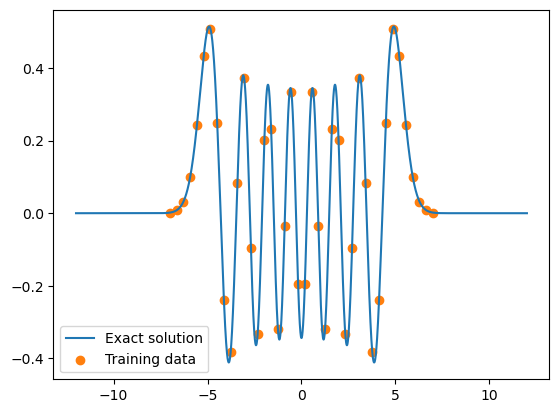

In [6]:
import torch
import numpy as np
from scipy.special import hermite
from scipy.special import factorial

def quantum_harmonic_oscillator(n, x):
    """
    Quantum harmonic oscillator state function for n-th energy level.

    Parameters:
    - n: Quantum number
    - x: Position (torch.Tensor)

    Returns:
    - y: The n-th state wave function evaluated at x
    """
    # Given values
    m = 1  # mass
    omega = 1  # angular frequency
    hbar = 1  # reduced Planck's constant
    prefactor = ((m*omega)/(np.pi*hbar))**0.25
    normalization = 1 / np.sqrt(2**n * factorial(n))
    x_np = x.numpy()
    # Calculate the Hermite polynomial H_n
    H_n = hermite(n)(np.sqrt(m*omega/hbar)*x_np)
    # Compute the wave function
    y_np = prefactor * normalization * H_n * np.exp(-m*omega*x_np**2 / (2*hbar))
    # Convert the result back to a torch.Tensor
    y = torch.from_numpy(y_np).type_as(x)
    return y
# get the analytical solution over the full domain
n = 14 # nth eigenstate
x = torch.linspace(-12,12,10000).view(-1,1) 
y = quantum_harmonic_oscillator(n, x).view(-1,1)
print(x.shape, y.shape)

# Generate 20 equally spaced data points within the range [-6.5, 6.5]
x_start, x_end = -7, 7
num_points = 40
x_data = torch.linspace(x_start, x_end, num_points).view(-1, 1)
y_data = quantum_harmonic_oscillator(n, x_data).view(-1, 1)
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

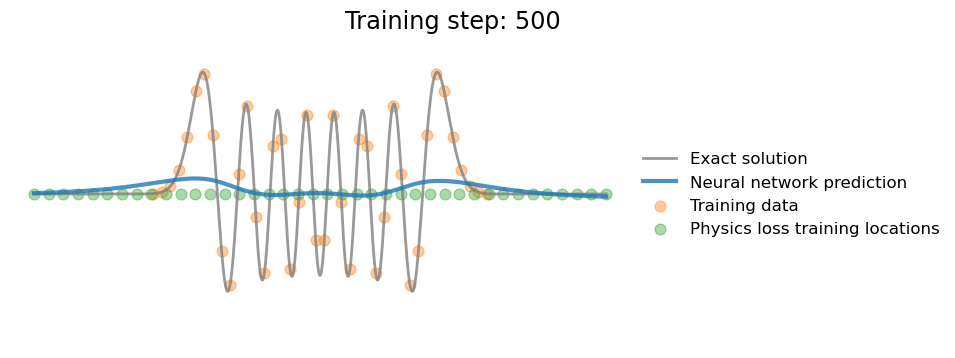

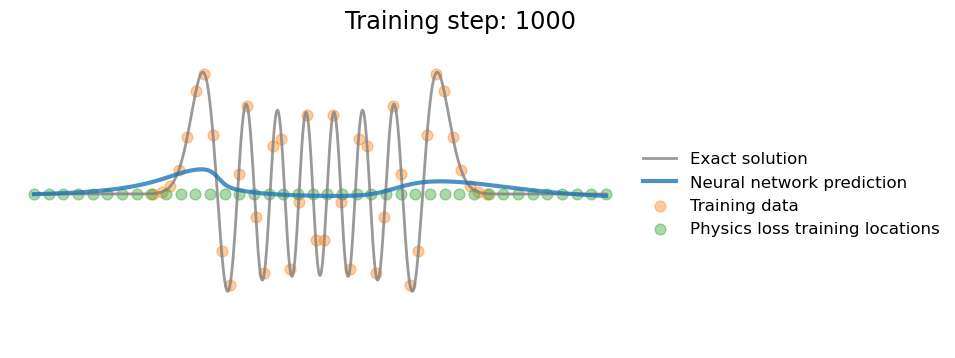

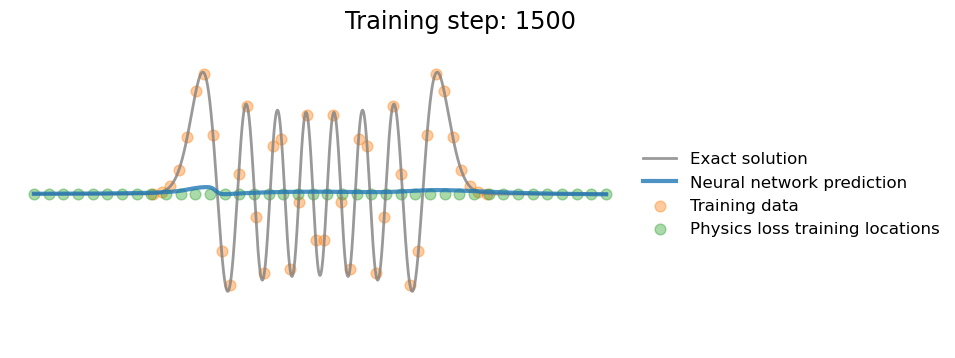

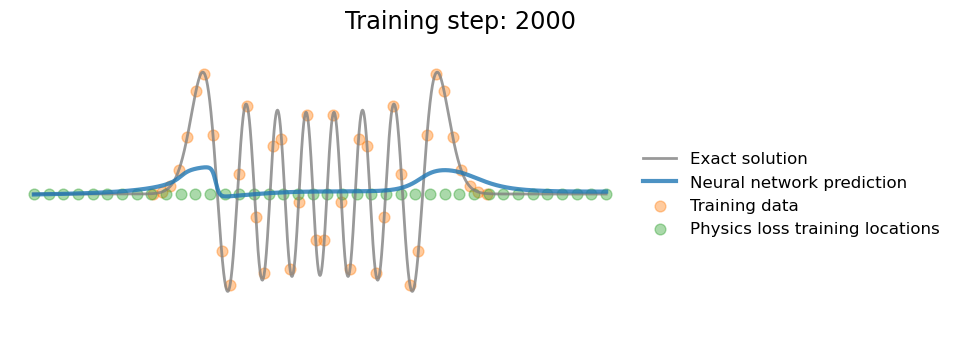

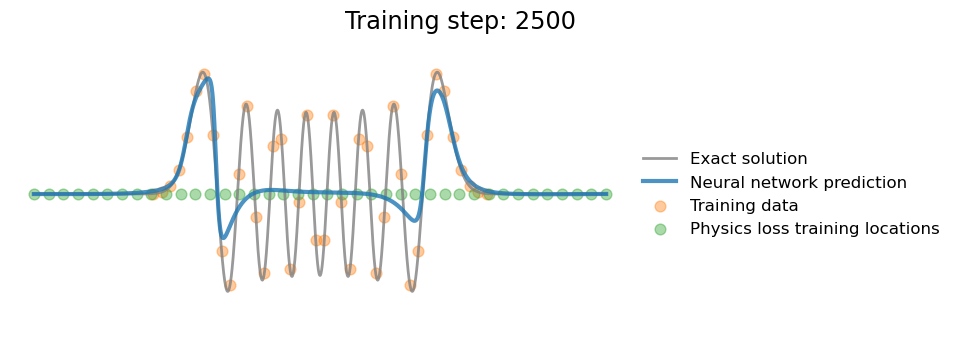

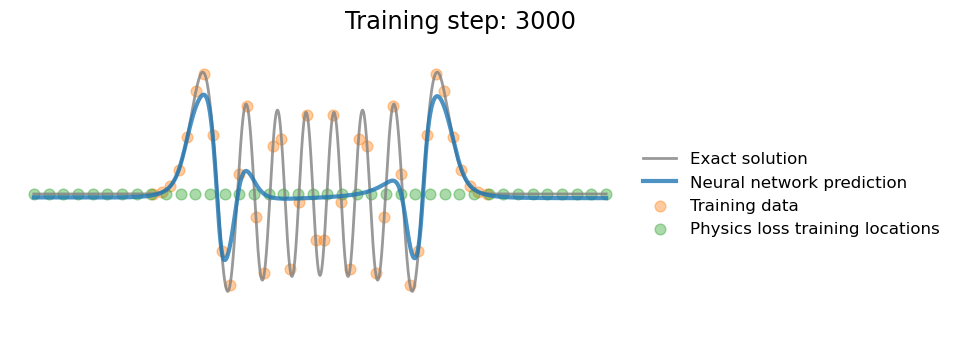

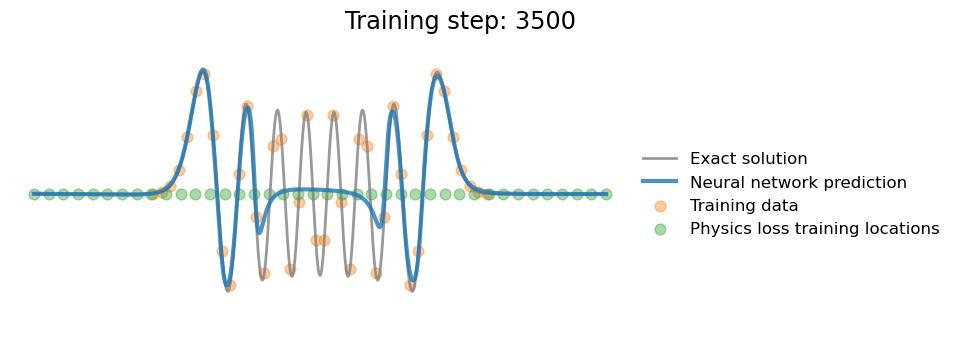

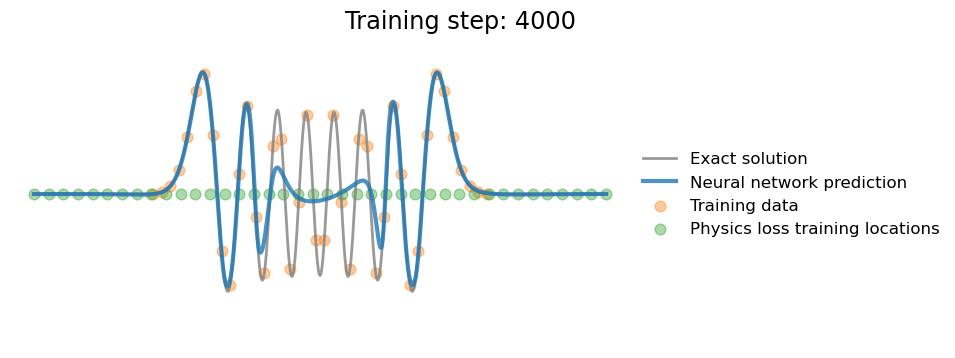

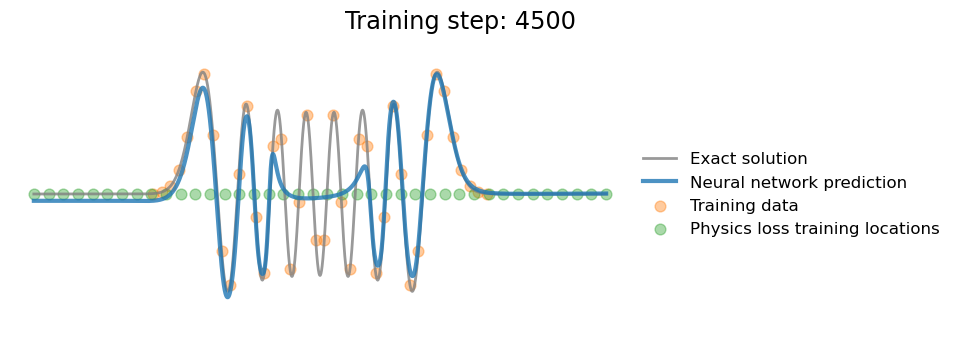

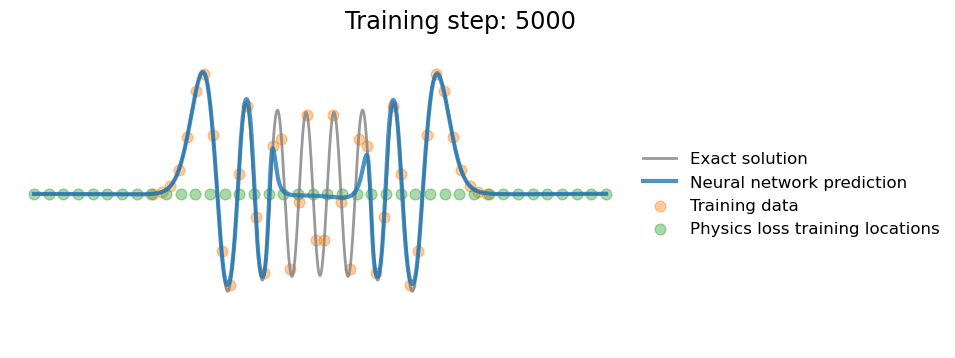

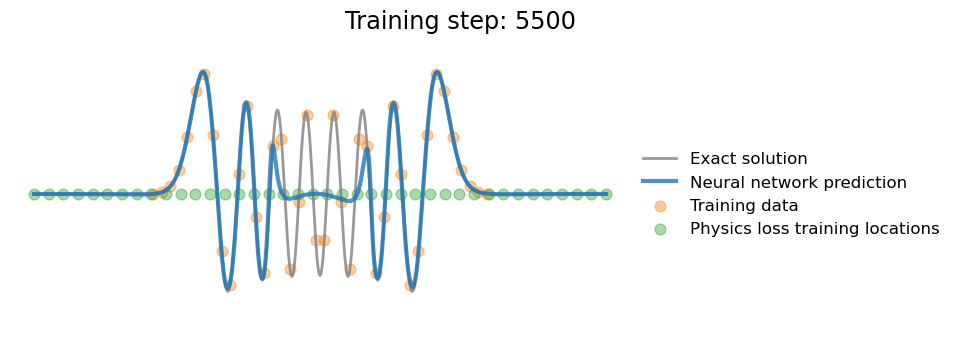

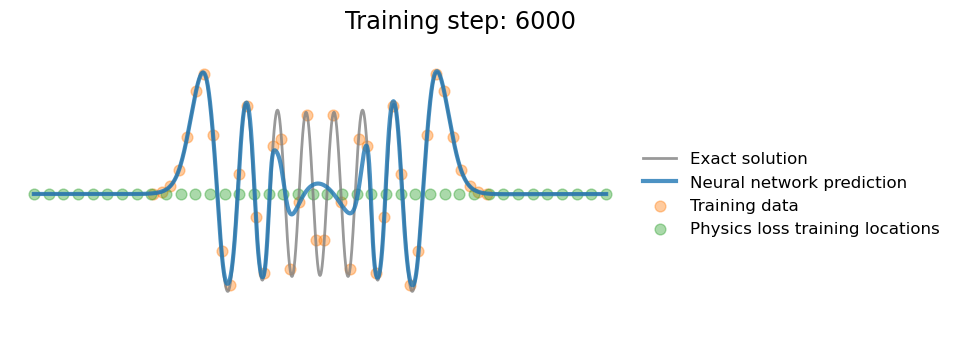

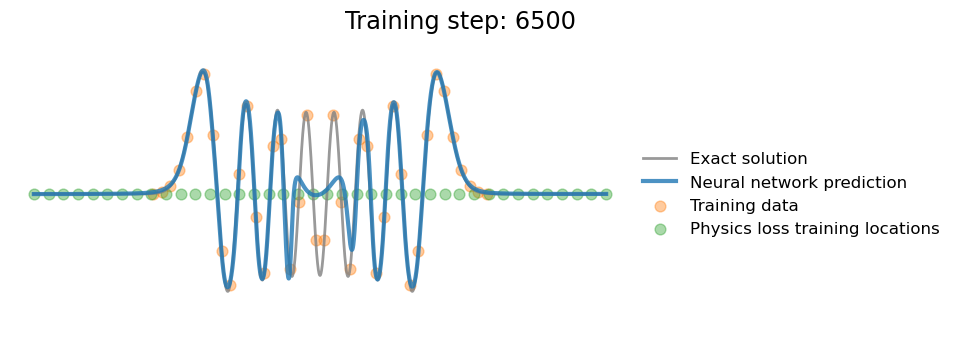

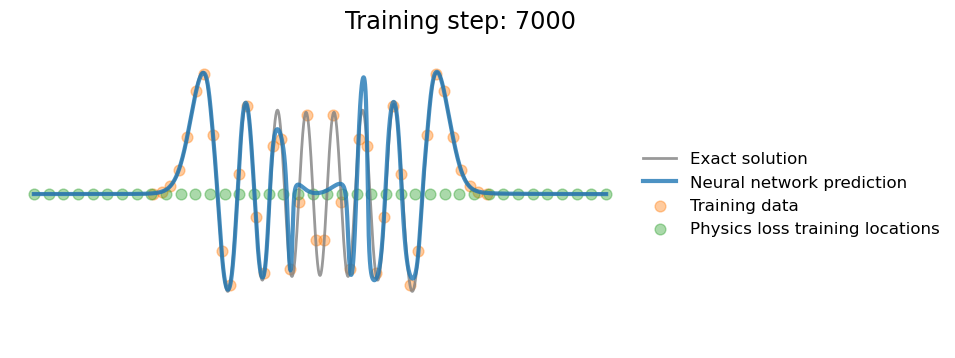

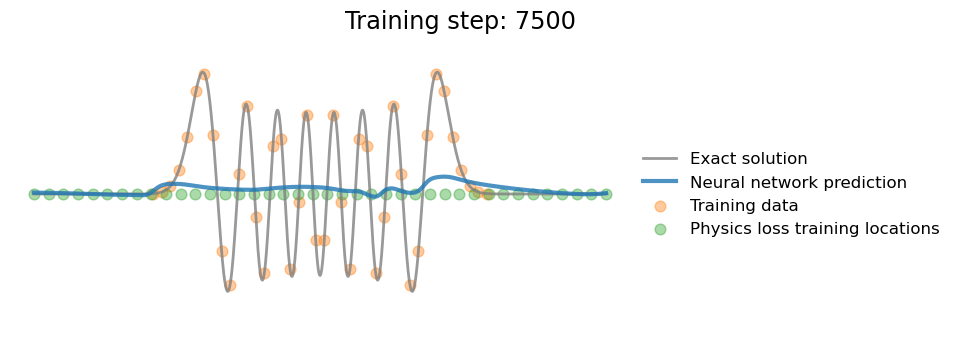

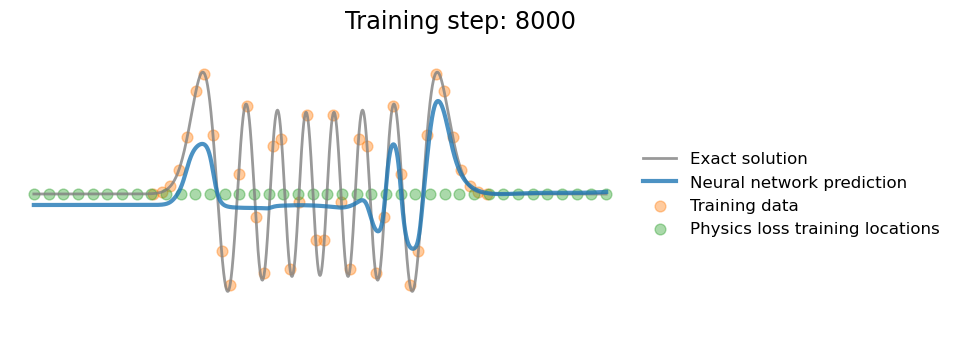

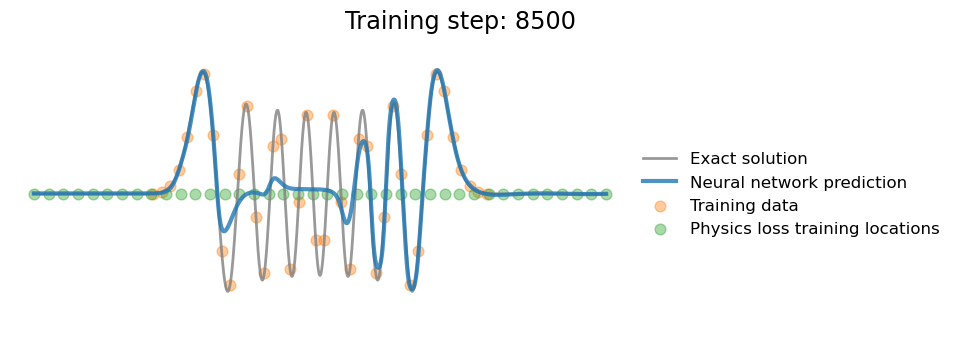

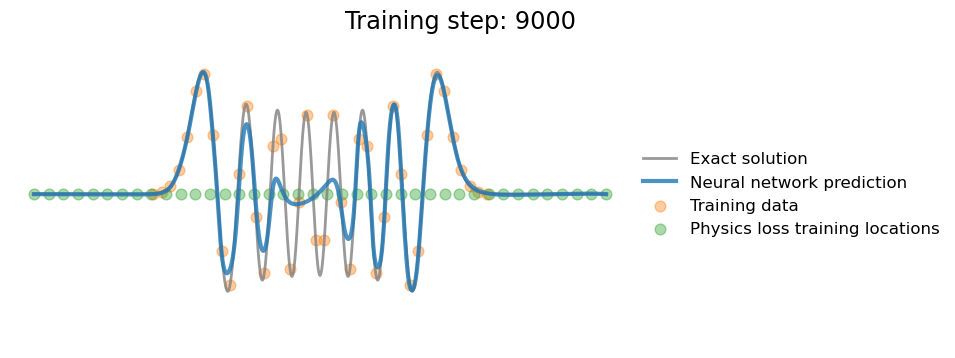

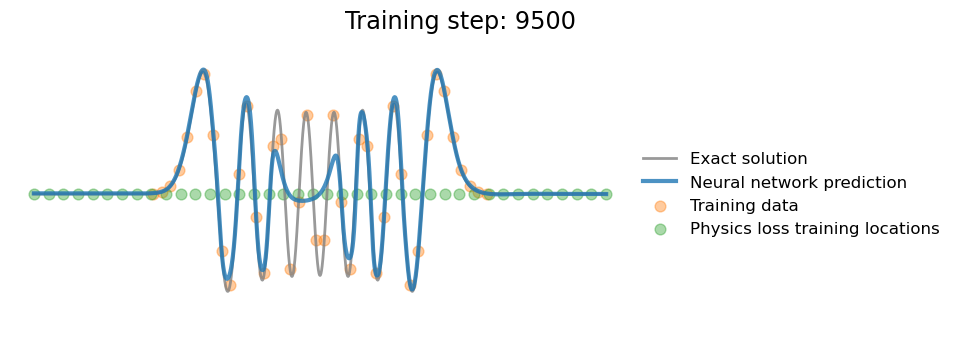

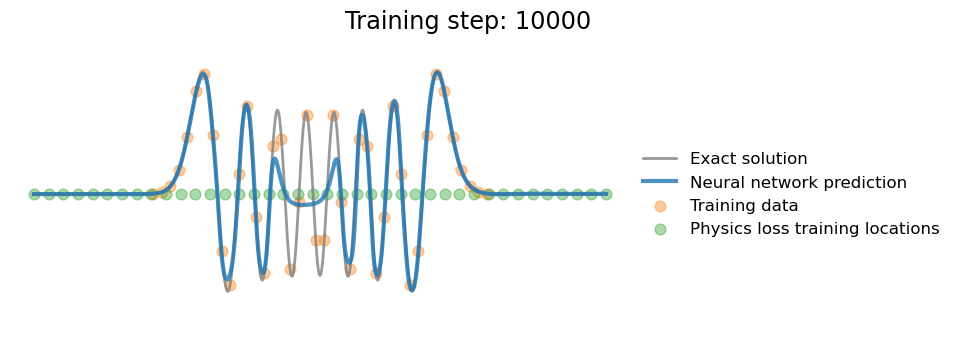

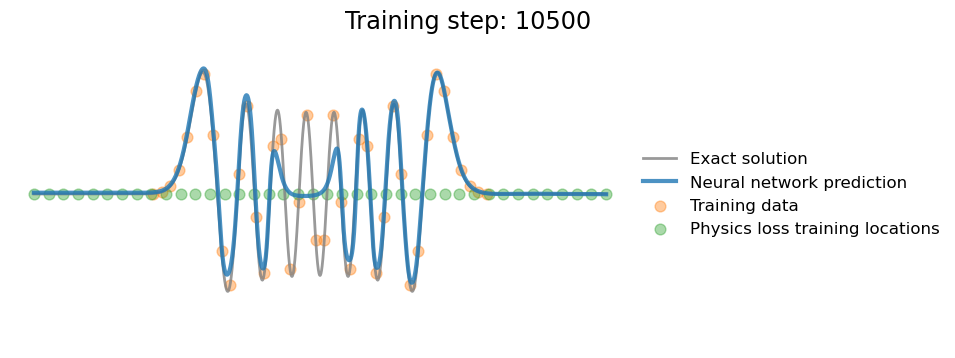

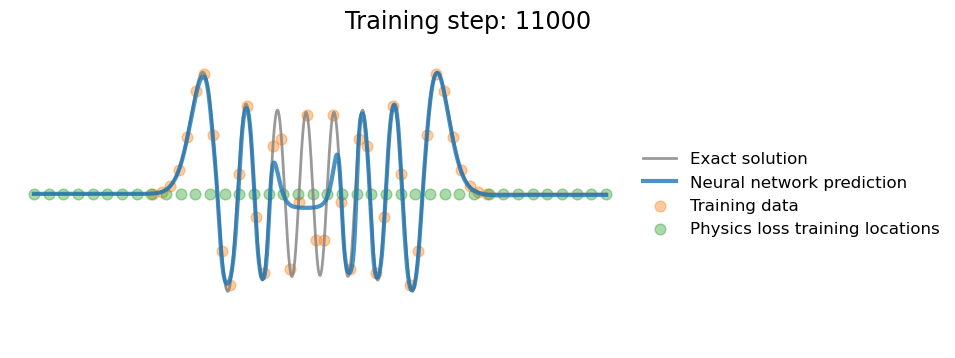

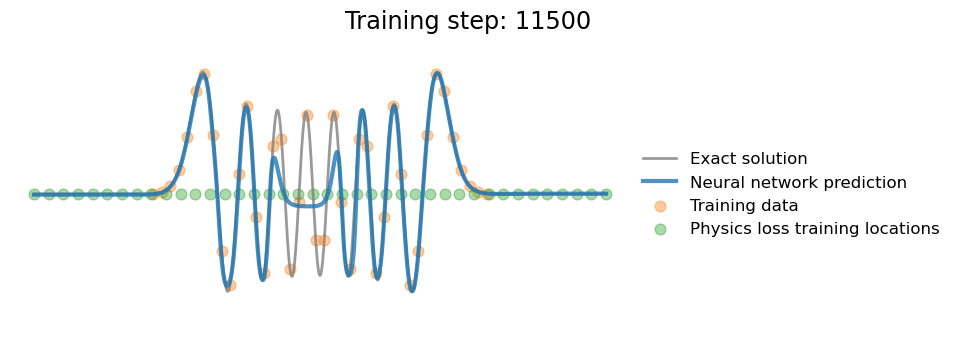

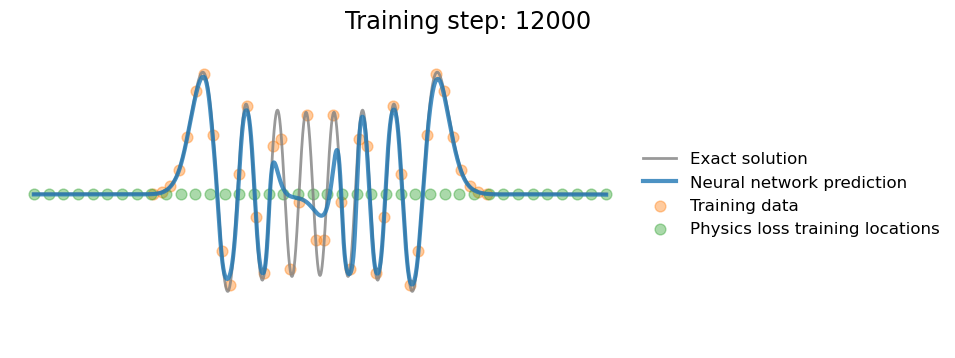

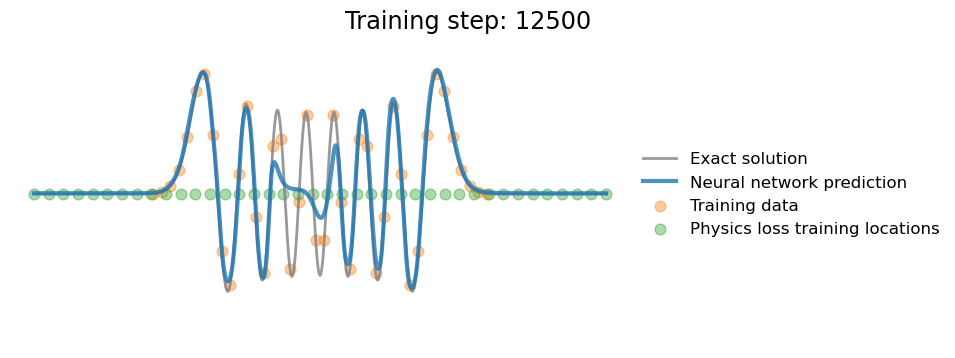

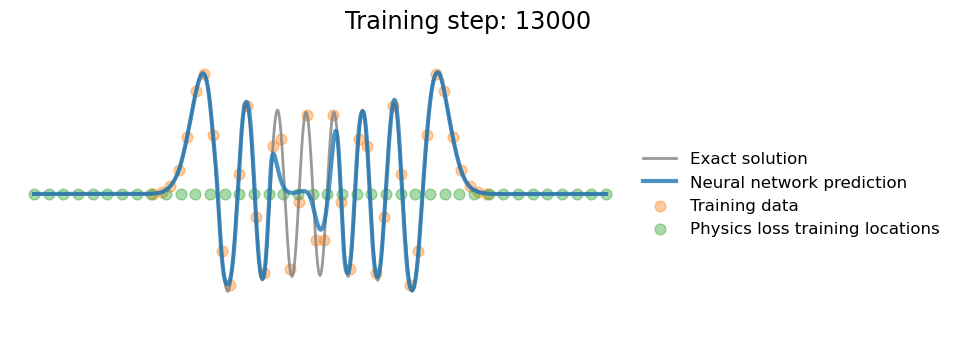

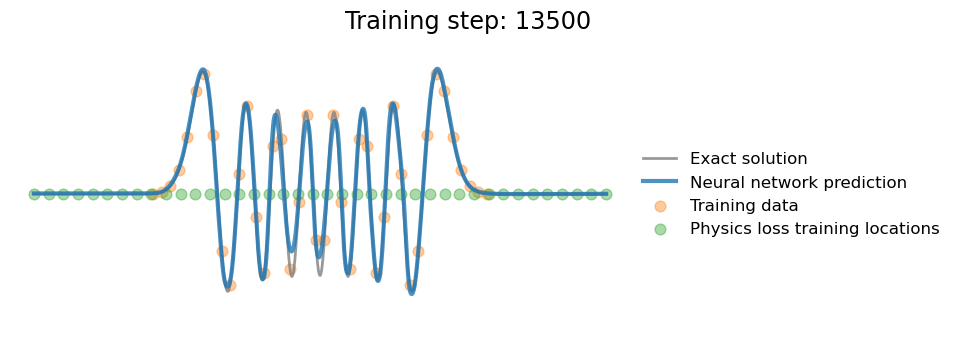

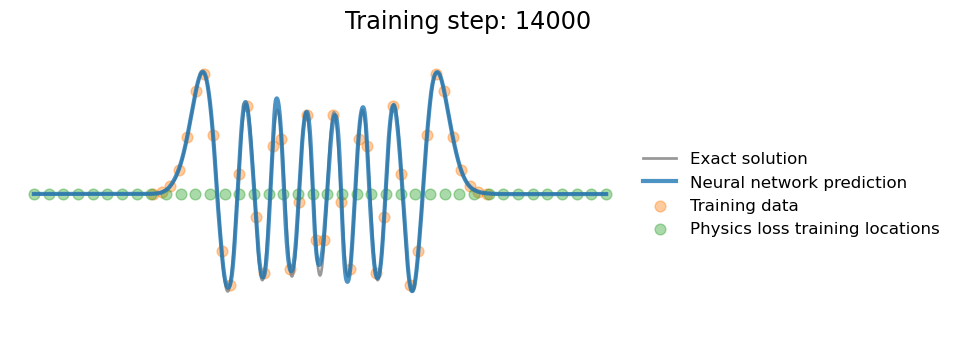

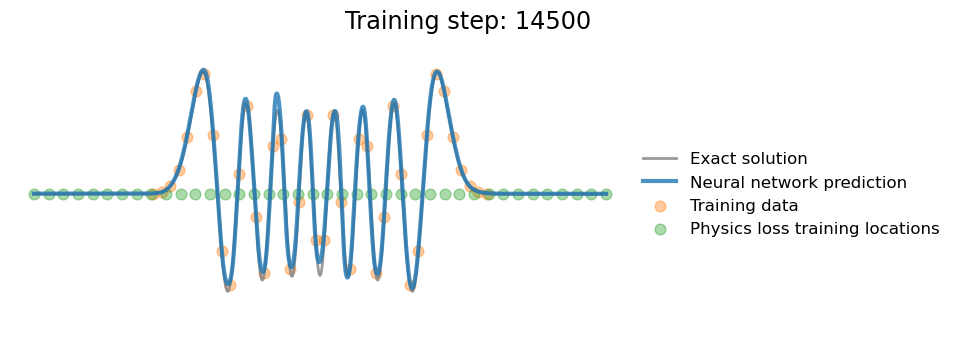

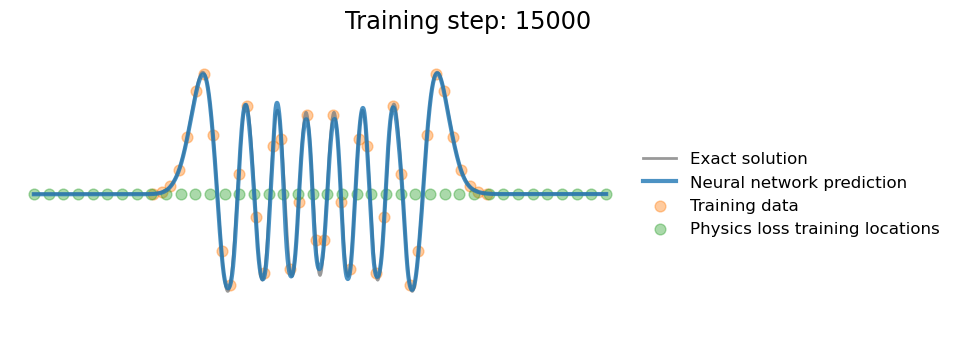

In [7]:
x_physics = torch.linspace(-12,12,40).view(-1,1).requires_grad_(True) # sample locations over the problem domain

torch.manual_seed(123)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCN(1, 1, 50, 6)

optimizer = torch.optim.Adam(model.parameters(),lr=5e-3)

files = []
for i in range(15000):
    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error# use mean squared error

    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 - (x_physics ** 2) * yhp + 2 * (n + 0.5) * yhp
    loss2 = (5e-3) * torch.mean(physics ** 2)

    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i+1) % 100 == 0:
        yh = model(x).detach()
        xp = x_physics.detach()
        xlim_low = -13
        xlim_high = 13
        ylim_low = -0.65
        ylim_high = 0.65
        plot_result(x,y,x_data,y_data,yh,xlim_low,xlim_high,ylim_low,ylim_high,xp)

        file = "qhm_pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")

save_gif_PIL("qhm_pinn.gif", files, fps=20, loop=0)

In [8]:
!rm -rf *.png

# 2-D PDE Problem example

We have been given a PDE: 
$$
\frac{du}{dx}=2 \frac{du}{dt}+u
$$
and boundary condition: 
$$
u(x,0)=6e^{-3x}
$$
- Independent variables: $x,t$ (input)
- Dependent variables: $u$ (outputs)

We have to find out $u(x,t) \forall x \in [0,2]$ and $t \in [0,1]$

Analytical the solution: 
$$
u(x,t) = 6e^{-3x-2t}
$$

In [9]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(FCN, self).__init__()
        self.activation = nn.Tanh()  # Define the activation function here
        self.initial_layer = nn.Linear(N_INPUT, N_HIDDEN)
        self.hidden_layers = nn.ModuleList([nn.Linear(N_HIDDEN, N_HIDDEN) for _ in range(N_LAYERS - 1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
    
    def forward(self, x, t):
        # Assuming x and t are already tensors, concatenate them along the appropriate axis
        inputs = torch.cat((x, t), dim=1)
        x = self.activation(self.initial_layer(inputs))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return x

net = FCN(2,1,5,5)
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

def f(x,t, net):
    u = net(x,t) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our f = du/dx - 2du/dt - u, we need du/dx and du/dt
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    physics_loss = u_x - 2*u_t - u
    return physics_loss

## Data from Boundary Conditions
# u(x,0)=6e^(-3x)
## BC just gives us datapoints for training

# BC tells us that for any x in range[0,2] and time=0, the value of u is given by 6e^(-3x)
# Take say 500 random numbers of x
x_bc = np.random.uniform(low=0.0, high=2.0, size=(500,1))
t_bc = np.zeros((500,1))
# compute u based on BC
u_bc = 6*np.exp(-3*x_bc)

### (3) Training / Fitting
#previous_validation_loss = 99999999.0
for epoch in range(20000):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc, pt_t_bc) # output of u(x,t)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1))
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    all_zeros = np.zeros((500,1))
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, pt_t_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    loss = mse_u + mse_f
    loss.backward() 
    optimizer.step() 
    with torch.autograd.no_grad():
        if epoch % 1000 == 0:
            print(epoch,"Training Loss:",loss.data)
    

0 Training Loss: tensor(2.7992, device='cuda:0')
1000 Training Loss: tensor(0.0502, device='cuda:0')
2000 Training Loss: tensor(0.0054, device='cuda:0')
3000 Training Loss: tensor(0.0018, device='cuda:0')
4000 Training Loss: tensor(0.0016, device='cuda:0')
5000 Training Loss: tensor(0.0008, device='cuda:0')
6000 Training Loss: tensor(0.0007, device='cuda:0')
7000 Training Loss: tensor(0.0004, device='cuda:0')
8000 Training Loss: tensor(0.0003, device='cuda:0')
9000 Training Loss: tensor(0.0002, device='cuda:0')
10000 Training Loss: tensor(0.0002, device='cuda:0')
11000 Training Loss: tensor(0.0002, device='cuda:0')
12000 Training Loss: tensor(0.0003, device='cuda:0')
13000 Training Loss: tensor(0.0002, device='cuda:0')
14000 Training Loss: tensor(0.0001, device='cuda:0')
15000 Training Loss: tensor(0.0003, device='cuda:0')
16000 Training Loss: tensor(8.2371e-05, device='cuda:0')
17000 Training Loss: tensor(7.8810e-05, device='cuda:0')
18000 Training Loss: tensor(5.2495e-05, device='cud

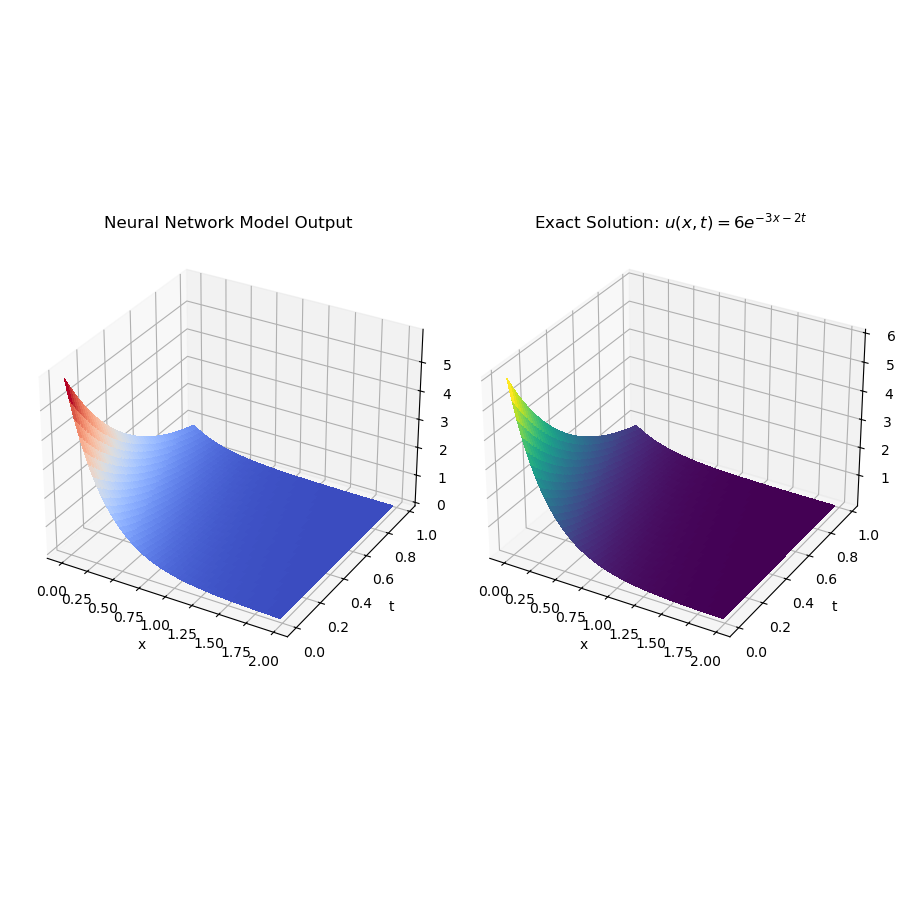

In [10]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import torch
from torch.autograd import Variable

fig = plt.figure(figsize=(9, 9))
ax1 = fig.add_subplot(121, projection='3d')  # Changed this line

x = np.arange(0, 2, 0.02)
t = np.arange(0, 1, 0.02)
ms_x, ms_t = np.meshgrid(x, t)
x = np.ravel(ms_x).reshape(-1, 1)
t = np.ravel(ms_t).reshape(-1, 1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_x, pt_t)
u = pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax1.plot_surface(ms_x, ms_t, ms_u, cmap=cm.coolwarm, linewidth=0, antialiased=False)
#fig.colorbar(surf, shrink=0.5, aspect=5, ax=ax1)

ax2 = fig.add_subplot(122, projection='3d')  # Second subplot for exact solution plot

# Generating the meshgrid for the exact solution
ms_u_exact = 6 * np.exp(-3*ms_x - 2*ms_t)

# Plotting the exact solution
surf2 = ax2.plot_surface(ms_x, ms_t, ms_u_exact, cmap=cm.viridis, linewidth=0, antialiased=False)

# Setting labels and titles for both plots
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('U(x, t)')
ax1.set_title('Neural Network Model Output')

ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('U(x, t)')
ax2.set_title('Exact Solution: $u(x,t) = 6e^{-3x-2t}$')

# Adding color bars for both plots
# Placeholder for the neural network model output plot colorbar
# fig.colorbar(surf1, shrink=0.5, aspect=5, ax=ax1)

#fig.colorbar(surf2, shrink=0.5, aspect=5, ax=ax2)

plt.tight_layout()
plt.show()

In [11]:
#torch.save(net.state_dict(), "model_uxt.pt")

# Symmetric infinite potential well using PINN

The potential is given by 
$$
V(x) = 
\begin{cases} 
0 & \text{for } 0 \leq x \leq L \\
\infty & \text{otherwise}
\end{cases}
$$

The time-dependent Schrödinger equation for a particle of mass $m$ in this potential is:

$$
i\hbar\frac{\partial}{\partial t}\Psi(x,t) = \left[-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x)\right]\Psi(x,t)
$$


### Inside the Well (\$0 < x < L\$)

Within the well, the potential $V(x) = 0$, so the time-dependent Schrödinger equation simplifies to:

$$
i\hbar\frac{\partial}{\partial t}\Psi(x,t) = -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\Psi(x,t)
$$

This equation can be solved by separation of variables, assuming $\Psi(x,t) = \psi(x)\phi(t)$. The solution for the spatial part, $\psi(x)$, inside the well is:

$$
\psi_n(x) = \sqrt{\frac{2}{L}}\sin\left(\frac{n\pi x}{L}\right), \quad n = 1, 2, 3, \ldots
$$

The corresponding time-dependent part, $\phi(t)$, is:

$$
\phi_n(t) = e^{-iE_nt/\hbar}
$$

where the energy levels $E_n$ are quantized and given by:

$$
E_n = \frac{n^2\pi^2\hbar^2}{2mL^2}, \quad n = 1, 2, 3, \ldots
$$

### Full Time-Dependent Solution

Combining the spatial and temporal parts, the full solution for the wave function inside the well is:

$$
\Psi_n(x,t) = \psi_n(x)\phi_n(t) = \sqrt{\frac{2}{L}}\sin\left(\frac{n\pi x}{L}\right)e^{-iE_nt/\hbar}
$$

### Boundary Condition 

$$ \Psi_n(x,0) = \sqrt{\frac{2}{L}}\sin\left(\frac{n\pi x}{L}\right), \quad n = 1, 2, 3, \ldots $$

$$ \Psi_n(0,t) = 0 $$

$$ \Psi_n(1,t) = 0 $$



- Independent variables: $x,t$ (input)
- Dependent variables: $\Psi$ (outputs)


We have to find out $\Psi(x,t) \forall x \in [0,1]$ and $t \in [0,1]$

We assume $m = 1, L = 1, \hbar = 1$ 

In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SchrodingerPINN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(SchrodingerPINN, self).__init__()
        self.activation = nn.Tanh()
        self.initial_layer = nn.Linear(N_INPUT, N_HIDDEN)
        self.hidden_layers = nn.ModuleList([nn.Linear(N_HIDDEN, N_HIDDEN) for _ in range(N_LAYERS - 1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)  # Output for both real and imaginary parts
    
    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)
        x = self.activation(self.initial_layer(inputs))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return x  # Output now includes both real and imaginary parts

def schrodinger_loss(net, x, t):
    psi = net(x, t)
    psi_r, psi_i = psi[:, 0:1], psi[:, 1:2]
    
    # Compute gradients for real and imaginary parts
    psi_r_t = torch.autograd.grad(psi_r.sum(), t, create_graph=True, retain_graph=True)[0]
    psi_i_t = torch.autograd.grad(psi_i.sum(), t, create_graph=True, retain_graph=True)[0]

    # Need to provide grad_outputs for non-scalar outputs when computing second derivatives
    ones_r = torch.ones(psi_r.shape, device=device)
    ones_i = torch.ones(psi_i.shape, device=device)

    psi_r_xx = torch.autograd.grad(torch.autograd.grad(psi_r, x, create_graph=True, grad_outputs=ones_r)[0], x, grad_outputs=ones_r, create_graph=True)[0]
    psi_i_xx = torch.autograd.grad(torch.autograd.grad(psi_i, x, create_graph=True, grad_outputs=ones_i)[0], x, grad_outputs=ones_i, create_graph=True)[0]
    
    # Implementing the Schrodinger equation loss
    loss = torch.mean((- psi_i_t + 0.5 * psi_r_xx) ** 2) + torch.mean((psi_r_t + 0.5 * psi_i_xx) ** 2)
    return loss


# Define the network, optimizer, etc.
N_INPUT = 2  # x and t
N_OUTPUT = 2  # Real and imaginary parts of Psi
N_HIDDEN = 50
N_LAYERS = 4

net = SchrodingerPINN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters())
mse_cost_function = torch.nn.MSELoss()

In [13]:
# MSE loss for the boundary condition
mse_cost_function = torch.nn.MSELoss()

# Preparing the initial wave function data for the boundary condition
x_bc = np.linspace(0, 1, 500)[:, None]  # Using linspace to ensure even coverage
t_bc = np.zeros((500, 1))
psi_bc = np.sqrt(2) * np.sin(np.pi * x_bc)  # Real part of Psi(x,0)
psi_bc_i = np.zeros_like(psi_bc)  # Imaginary part is zero at t=0

x_bc_0 = np.zeros((500,1))
x_bc_l = np.ones((500,1))
psi_bc_0 = np.zeros_like(psi_bc)

# Training loop
for epoch in range(20000):
    optimizer.zero_grad()  # Reset gradients
    
    # boundary condition \psi(x,0) #Real part of Psi(x,0) but imaginary part of Psi(x,0) = 0
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_psi_bc = Variable(torch.from_numpy(np.hstack([psi_bc, psi_bc_i])).float(), requires_grad=False).to(device)
    net_bc_out = net(pt_x_bc, pt_t_bc)
    boundary_loss_t = mse_cost_function(net_bc_out, pt_psi_bc)

    # boundary condition \psi(0,t)=0
    pt_x_bc_l = Variable(torch.from_numpy(x_bc_0).float(), requires_grad=False).to(device)
    t_bc_l = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    pt_t_bc_l = Variable(torch.from_numpy(t_bc_l).float(), requires_grad=False).to(device)
    pt_psi_bc_l = Variable(torch.from_numpy(np.hstack([psi_bc_0, psi_bc_i])).float(), requires_grad=False).to(device)
    net_bc_out_l = net(pt_x_bc_l, pt_t_bc_l)
    boundary_loss_l = mse_cost_function(net_bc_out_l, pt_psi_bc_l)

    # boundary condition \psi(1,t)=0
    pt_x_bc_r = Variable(torch.from_numpy(x_bc_l).float(), requires_grad=False).to(device)
    t_bc_r = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    pt_t_bc_r = Variable(torch.from_numpy(t_bc_r).float(), requires_grad=False).to(device)
    pt_psi_bc_r = Variable(torch.from_numpy(np.hstack([psi_bc_0, psi_bc_i])).float(), requires_grad=False).to(device)
    net_bc_out_r = net(pt_x_bc_r, pt_t_bc_r)
    boundary_loss_r = mse_cost_function(net_bc_out_r, pt_psi_bc_r)
    
    # Prepare random collocation points for PDE loss
    x_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    
    # Compute the physics-informed loss
    physics_loss = schrodinger_loss(net, pt_x_collocation, pt_t_collocation)
    
    # Total loss is the sum of boundary loss and physics-informed loss
    total_loss = boundary_loss_t + physics_loss + boundary_loss_l + boundary_loss_r
    total_loss.backward()
    optimizer.step()
    
    with torch.autograd.no_grad():
        if epoch % 1000 == 0:
            print(epoch,"Training Loss:",total_loss.data)

0 Training Loss: tensor(0.5017, device='cuda:0')
1000 Training Loss: tensor(0.0313, device='cuda:0')
2000 Training Loss: tensor(0.0081, device='cuda:0')
3000 Training Loss: tensor(0.0047, device='cuda:0')
4000 Training Loss: tensor(0.0020, device='cuda:0')
5000 Training Loss: tensor(0.0015, device='cuda:0')
6000 Training Loss: tensor(0.0015, device='cuda:0')
7000 Training Loss: tensor(0.0006, device='cuda:0')
8000 Training Loss: tensor(0.0007, device='cuda:0')
9000 Training Loss: tensor(0.0015, device='cuda:0')
10000 Training Loss: tensor(0.0014, device='cuda:0')
11000 Training Loss: tensor(0.0008, device='cuda:0')
12000 Training Loss: tensor(0.0006, device='cuda:0')
13000 Training Loss: tensor(0.0014, device='cuda:0')
14000 Training Loss: tensor(0.0007, device='cuda:0')
15000 Training Loss: tensor(0.0012, device='cuda:0')
16000 Training Loss: tensor(0.0004, device='cuda:0')
17000 Training Loss: tensor(0.0012, device='cuda:0')
18000 Training Loss: tensor(0.0004, device='cuda:0')
19000 

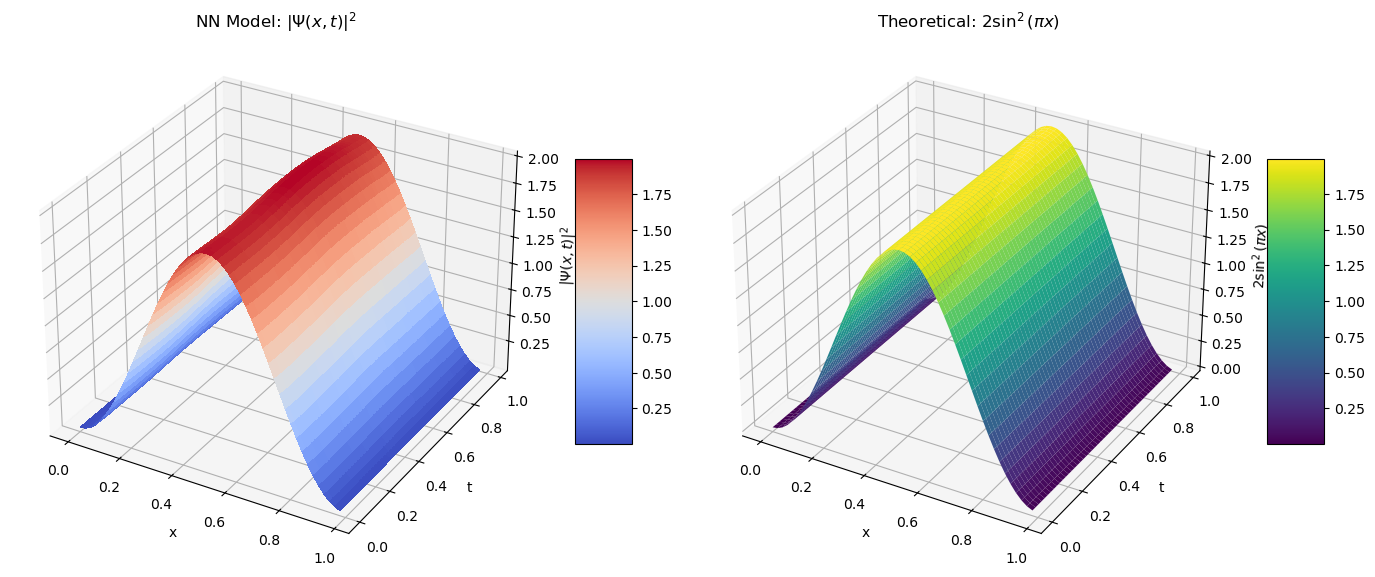

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import torch
from torch.autograd import Variable

plt.close()
# Prepare the meshgrid
x = np.arange(0, 1, 0.02)
t = np.arange(0, 1, 0.02)
ms_x, ms_t = np.meshgrid(x, t)
x_flat = np.ravel(ms_x).reshape(-1, 1)
t_flat = np.ravel(ms_t).reshape(-1, 1)

# Convert to torch tensors and evaluate using the trained model
pt_x = Variable(torch.from_numpy(x_flat).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t_flat).float(), requires_grad=True).to(device)
pt_psi = net(pt_x, pt_t)
psi = pt_psi.data.cpu().numpy()

# Separate real and imaginary parts of Psi, then compute |Psi|^2
psi_r, psi_i = psi[:, 0], psi[:, 1]
psi_squared = psi_r**2 + psi_i**2
ms_psi_squared = psi_squared.reshape(ms_x.shape)

# Theoretical probability density: 2 * sin^2(pi*x)
ms_theoretical = 2 * np.sin(np.pi * ms_x)**2

# Plotting
fig = plt.figure(figsize=(14, 6))

# Neural Network Model Output
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(ms_x, ms_t, ms_psi_squared, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel(r'$|\Psi(x, t)|^2$')
ax1.set_title(r'NN Model: $|\Psi(x, t)|^2$')
fig.colorbar(surf1, shrink=0.5, aspect=5, ax=ax1)

# Theoretical/Reference Probability Density
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(ms_x, ms_t, ms_theoretical, cmap=cm.viridis, linewidth=0, antialiased=True)
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel(r'$2\sin^2(\pi x)$')
ax2.set_title(r'Theoretical: $2\sin^2(\pi x)$')
fig.colorbar(surf2, shrink=0.5, aspect=5, ax=ax2)

plt.tight_layout()
plt.show()


# Non linear Schrodinger equation with periodic boundary as in PINN paper

Assume $\hbar = 1, m = 1$
So the differential equation becomes
$$
i \frac{\partial \psi}{\partial t} + \frac{1}{2} \frac{\partial^2 \psi}{\partial x^2} + |\psi|^2 \psi = 0, \quad x \in [-5, 5], \quad t \in [0, \frac{\pi}{2}],
$$
and the boundary conditions are given by
$$
\psi(x,0) = 2 \, \text{sech}(x),
$$

$$
\psi(-5,t) = \psi(5,t),
$$

$$
\left. \frac{\partial \psi}{\partial x} \right|_{x=-5,t} = \left. \frac{\partial \psi}{\partial x} \right|_{x=5,t}
$$


In [13]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SchrodingerPINN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(SchrodingerPINN, self).__init__()
        self.activation = nn.Tanh()
        self.initial_layer = nn.Linear(N_INPUT, N_HIDDEN)
        self.hidden_layers = nn.ModuleList([nn.Linear(N_HIDDEN, N_HIDDEN) for _ in range(N_LAYERS - 1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)  # Output for both real and imaginary parts
    
    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)
        x = self.activation(self.initial_layer(inputs))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return x  # Output now includes both real and imaginary parts

def schrodinger_loss(net, x, t):
    psi = net(x, t)
    psi_r, psi_i = psi[:, 0:1], psi[:, 1:2]
    
    # Compute gradients for real and imaginary parts
    psi_r_t = torch.autograd.grad(psi_r.sum(), t, create_graph=True, retain_graph=True)[0]
    psi_i_t = torch.autograd.grad(psi_i.sum(), t, create_graph=True, retain_graph=True)[0]

    # Need to provide grad_outputs for non-scalar outputs when computing second derivatives
    ones_r = torch.ones(psi_r.shape, device=device)
    ones_i = torch.ones(psi_i.shape, device=device)

    psi_r_xx = torch.autograd.grad(torch.autograd.grad(psi_r, x, create_graph=True, grad_outputs=ones_r)[0], x, grad_outputs=ones_r, create_graph=True)[0]
    psi_i_xx = torch.autograd.grad(torch.autograd.grad(psi_i, x, create_graph=True, grad_outputs=ones_i)[0], x, grad_outputs=ones_i, create_graph=True)[0]
    
    # Implementing the Schrodinger equation loss
    real = torch.mean( ( ( -psi_i_t + 0.5 * psi_r_xx) + (psi_r ** 2 + psi_i ** 2)* psi_r ) **2 )
    imag = torch.mean( ( ( psi_r_t + 0.5 * psi_i_xx) + (psi_r ** 2 + psi_i ** 2)* psi_i ) **2 )
    return real + imag

# Define the network, optimizer, etc.
N_INPUT = 2  # x and t
N_OUTPUT = 2  # Real and imaginary parts of Psi
N_HIDDEN = 50
N_LAYERS = 5

net = SchrodingerPINN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)
net = net.to(device)
#optimizer = torch.optim.Adam(net.parameters(),weight_decay=1e-5)
#optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-5)  # Adjust initial learning rate as needed
optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-5)  # Adjust initial learning rate as needed
#scheduler = StepLR(optimizer, step_size=10000, gamma=0.1)  # Reduce lr by a factor of 0.1 every 5000 epochs
mse_cost_function = torch.nn.MSELoss()

# MSE loss for the boundary condition
mse_cost_function = torch.nn.MSELoss()

sample_size = 2000

# Preparing the initial wave function data for the boundary condition
x_bc = np.linspace(-5, 5, sample_size)[:, None]  # Using linspace to ensure even coverage
t_bc = np.zeros((sample_size, 1))
psi_bc = 2/(np.cosh(x_bc))  # Real part of Psi(x,0)
psi_bc_i = np.zeros_like(psi_bc)  # Imaginary part is zero at t=0

x_bc_l = np.ones((sample_size,1))*(-5)
x_bc_r = x_bc_l*(-1)
psi_bc_0 = np.zeros_like(psi_bc)

# Training loop
for epoch in range(75000):
    optimizer.zero_grad()  # Reset gradients
    
    # boundary condition \psi(x,0) = 2 sech(x)
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_psi_bc = Variable(torch.from_numpy(np.hstack([psi_bc, psi_bc_i])).float(), requires_grad=False).to(device)
    net_bc_out = net(pt_x_bc, pt_t_bc)
    boundary_loss_t = mse_cost_function(net_bc_out, pt_psi_bc)

    # boundary condition \psi(-5,t)= /psi (5, t)
    pt_x_bc_l = Variable(torch.from_numpy(x_bc_l).float(), requires_grad=True).to(device)
    t = np.random.uniform(low=0.0, high=(np.pi/2), size=(sample_size,1))
    pt_t = Variable(torch.from_numpy(t).float(), requires_grad=False).to(device)
    net_bc_out_l = net(pt_x_bc_l, pt_t)
    
    pt_x_bc_r = Variable(torch.from_numpy(x_bc_r).float(), requires_grad=True).to(device)
    net_bc_out_r = net(pt_x_bc_r, pt_t)

    boundary_loss_x = mse_cost_function(net_bc_out_l, net_bc_out_r)

    # boundary condition \psi_x(-5,t)= \psi_x(5,t)
    grad_out_l = torch.autograd.grad(net_bc_out_l.sum(), pt_x_bc_l, create_graph=True)[0]
    grad_out_r = torch.autograd.grad(net_bc_out_r.sum(), pt_x_bc_r, create_graph=True)[0]
    boundary_loss_xx = mse_cost_function(grad_out_l, grad_out_r)
    
    # Prepare random collocation points for PDE loss
    x_collocation = np.random.uniform(low=-5.0, high=5.0, size=(sample_size,1))
    t_collocation = np.random.uniform(low=0.0, high=(np.pi/2), size=(sample_size,1))
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    
    # Compute the physics-informed loss
    physics_loss = schrodinger_loss(net, pt_x_collocation, pt_t_collocation)
    
    # Total loss is the sum of boundary loss and physics-informed loss
    total_loss = boundary_loss_t + physics_loss + boundary_loss_x + boundary_loss_xx
    total_loss.backward()
    optimizer.step()
    #scheduler.step()
    with torch.autograd.no_grad():
        if epoch % 1000 == 0:
            print(epoch,"Training Loss:",total_loss.data)

0 Training Loss: tensor(0.4973, device='cuda:0')
1000 Training Loss: tensor(0.0277, device='cuda:0')
2000 Training Loss: tensor(0.0211, device='cuda:0')
3000 Training Loss: tensor(0.0208, device='cuda:0')
4000 Training Loss: tensor(0.0146, device='cuda:0')
5000 Training Loss: tensor(0.0127, device='cuda:0')
6000 Training Loss: tensor(0.0116, device='cuda:0')
7000 Training Loss: tensor(0.0151, device='cuda:0')
8000 Training Loss: tensor(0.0103, device='cuda:0')
9000 Training Loss: tensor(0.0087, device='cuda:0')
10000 Training Loss: tensor(0.0077, device='cuda:0')
11000 Training Loss: tensor(0.0073, device='cuda:0')
12000 Training Loss: tensor(0.0070, device='cuda:0')
13000 Training Loss: tensor(0.0126, device='cuda:0')
14000 Training Loss: tensor(0.0053, device='cuda:0')
15000 Training Loss: tensor(0.0048, device='cuda:0')
16000 Training Loss: tensor(0.0042, device='cuda:0')
17000 Training Loss: tensor(0.0036, device='cuda:0')
18000 Training Loss: tensor(0.0035, device='cuda:0')
19000 

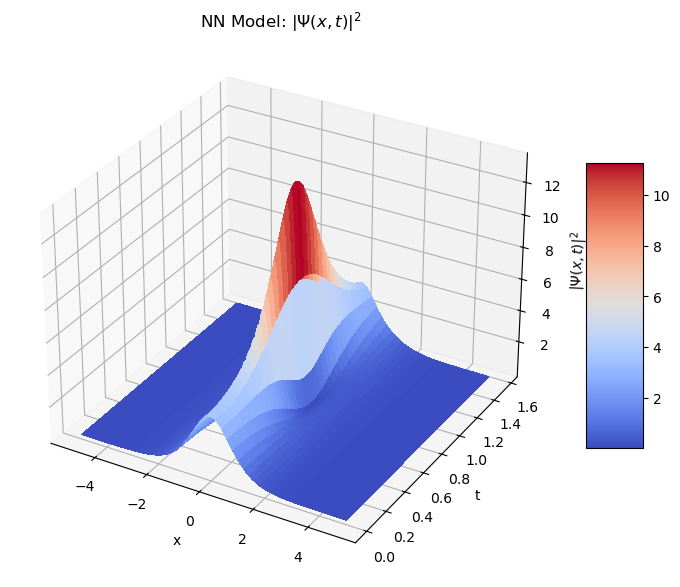

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import torch
from torch.autograd import Variable

plt.close()
# Prepare the meshgrid
x = np.arange(-5, 5, 0.02)
t = np.arange(0, np.pi/2, 0.02)
ms_x, ms_t = np.meshgrid(x, t)
x_flat = np.ravel(ms_x).reshape(-1, 1)
t_flat = np.ravel(ms_t).reshape(-1, 1)

# Convert to torch tensors and evaluate using the trained model
pt_x = Variable(torch.from_numpy(x_flat).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t_flat).float(), requires_grad=True).to(device)
pt_psi = net(pt_x, pt_t)
psi = pt_psi.data.cpu().numpy()

# Separate real and imaginary parts of Psi, then compute |Psi|^2
psi_r, psi_i = psi[:, 0], psi[:, 1]
psi_squared = psi_r**2 + psi_i**2
ms_psi_squared = psi_squared.reshape(ms_x.shape)

# Plotting
fig = plt.figure(figsize=(14, 6))

# Neural Network Model Output
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(ms_x, ms_t, ms_psi_squared, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel(r'$|\Psi(x, t)|^2$')
ax1.set_title(r'NN Model: $|\Psi(x, t)|^2$')
fig.colorbar(surf1, shrink=0.5, aspect=5, ax=ax1)

plt.tight_layout()
plt.show()


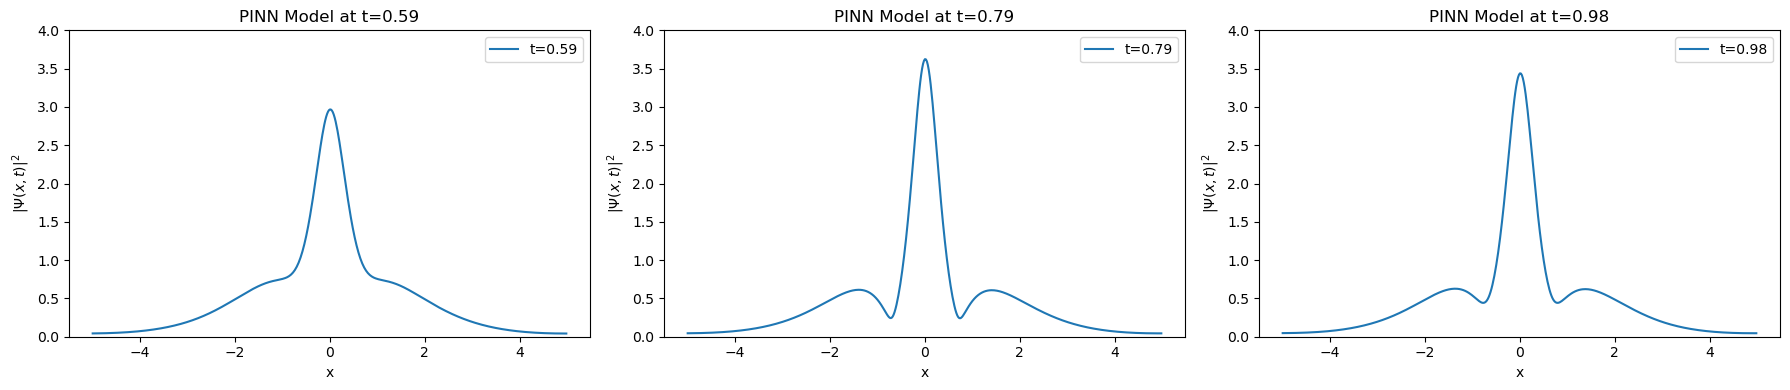

In [16]:
plt.close()

# Define the specific t values and prepare x
x = np.arange(-5, 5, 0.02)
t_values = [0.59, 0.79, 0.98]

# Create a figure
fig, axs = plt.subplots(1, len(t_values), figsize=(18, 4))

for i, t_val in enumerate(t_values):
    # Create a constant t array matching the length of x
    t_fixed = np.full(x.shape, t_val)
    
    # Convert to torch tensors
    # Convert to torch tensors
    pt_x = Variable(torch.from_numpy(x).float().view(-1, 1), requires_grad=True).to(device)
    pt_t = Variable(torch.from_numpy(t_fixed).float().view(-1, 1), requires_grad=True).to(device)

    
    # Evaluate the model
    pt_psi = net(pt_x, pt_t)
    psi = pt_psi.data.cpu().numpy()
    
    # Compute |Psi|^2
    psi_r, psi_i = psi[:, 0], psi[:, 1]
    psi_squared = psi_r**2 + psi_i**2
    psi = psi_squared ** 0.5
    
    # Plotting
    axs[i].plot(x, psi, label=f't={t_val}')
    axs[i].set_xlabel('x')
    axs[i].set_ylim(0,4.0)
    axs[i].set_ylabel(r'$|\Psi(x, t)|^2$')
    axs[i].set_title(f'PINN Model at t={t_val}')
    axs[i].legend()

plt.tight_layout()
plt.show()


# testing batch 

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SchrodingerPINN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(SchrodingerPINN, self).__init__()
        self.activation = nn.Tanh()
        self.initial_layer = nn.Linear(N_INPUT, N_HIDDEN)
        self.hidden_layers = nn.ModuleList([nn.Linear(N_HIDDEN, N_HIDDEN) for _ in range(N_LAYERS - 1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)  # Output for both real and imaginary parts
    
    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)
        x = self.activation(self.initial_layer(inputs))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return x  # Output now includes both real and imaginary parts

def schrodinger_loss(net, x, t):
    psi = net(x, t)
    psi_r, psi_i = psi[:, 0:1], psi[:, 1:2]
    
    # Compute gradients for real and imaginary parts
    psi_r_t = torch.autograd.grad(psi_r.sum(), t, create_graph=True, retain_graph=True)[0]
    psi_i_t = torch.autograd.grad(psi_i.sum(), t, create_graph=True, retain_graph=True)[0]

    # Need to provide grad_outputs for non-scalar outputs when computing second derivatives
    ones_r = torch.ones(psi_r.shape, device=device)
    ones_i = torch.ones(psi_i.shape, device=device)

    psi_r_xx = torch.autograd.grad(torch.autograd.grad(psi_r, x, create_graph=True, grad_outputs=ones_r)[0], x, grad_outputs=ones_r, create_graph=True)[0]
    psi_i_xx = torch.autograd.grad(torch.autograd.grad(psi_i, x, create_graph=True, grad_outputs=ones_i)[0], x, grad_outputs=ones_i, create_graph=True)[0]
    
    # Implementing the Schrodinger equation loss
    real = torch.mean( ( ( -psi_i_t + 0.5 * psi_r_xx) + (psi_r ** 2 + psi_i ** 2)* psi_r ) **2 )
    imag = torch.mean( ( ( psi_r_t + 0.5 * psi_i_xx) + (psi_r ** 2 + psi_i ** 2)* psi_i ) **2 )
    return real + imag

# Define the network, optimizer, etc.
N_INPUT = 2  # x and t
N_OUTPUT = 2  # Real and imaginary parts of Psi
N_HIDDEN = 40
N_LAYERS = 5

net = SchrodingerPINN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)
net = net.to(device)
#optimizer = torch.optim.Adam(net.parameters(),weight_decay=1e-5)
#optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-5)  # Adjust initial learning rate as needed
optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-5)  # Adjust initial learning rate as needed
#scheduler = StepLR(optimizer, step_size=10000, gamma=0.1)  # Reduce lr by a factor of 0.1 every 5000 epochs
mse_loss = torch.nn.MSELoss()

sample_size = 2000

# Boundary conditions datasets
# Initial condition at t=0
x_bc_initial = np.linspace(-5, 5, sample_size)[:, None]
t_bc_initial = np.zeros((sample_size, 1))
psi_bc_initial = 2 / (np.cosh(x_bc_initial))  # Real part of Psi(x,0), imaginary part is assumed zero

# Boundary conditions at x=-5 and x=5
x_bc_boundary_l = np.full((sample_size, 1), -5)
x_bc_boundary_r = np.full((sample_size, 1), 5)
t_bc_boundary = np.linspace(0, np.pi/2, sample_size).reshape(-1, 1)

# Collocation points for PDE
x_collocation = np.random.uniform(-5, 5, sample_size).reshape(-1, 1)
t_collocation = np.random.uniform(0, np.pi/2, sample_size).reshape(-1, 1)

# Combine datasets if necessary or keep separate
# For simplicity, let's proceed with the idea of keeping them separate for clarity

# Convert to tensors
tensor_x_bc_initial = torch.tensor(np.hstack((x_bc_initial, t_bc_initial)), dtype=torch.float).to(device)
tensor_psi_bc_initial = torch.tensor(psi_bc_initial, dtype=torch.float).to(device)

tensor_x_bc_boundary_l = torch.tensor(np.hstack((x_bc_boundary_l, t_bc_boundary)), dtype=torch.float).to(device)
tensor_x_bc_boundary_r = torch.tensor(np.hstack((x_bc_boundary_r, t_bc_boundary)), dtype=torch.float).to(device)

tensor_x_collocation = torch.tensor(np.hstack((x_collocation, t_collocation)), dtype=torch.float).to(device)

# DataLoader for initial boundary conditions
dataset_initial = TensorDataset(tensor_x_bc_initial, tensor_psi_bc_initial)
dataloader_initial = DataLoader(dataset_initial, batch_size=64, shuffle=True)

# DataLoader for boundary conditions at x=-5 and x=5
dataset_boundary_condition = TensorDataset(tensor_x_bc_boundary_l[:, 1:], tensor_x_bc_boundary_r[:, 1:])  
# Use t from either left or right as they are the same
dataloader_boundary_condition = DataLoader(dataset_boundary_condition, batch_size=64, shuffle=True)

# DataLoader for collocation points
dataset_collocation = TensorDataset(tensor_x_collocation)
dataloader_collocation = DataLoader(dataset_collocation, batch_size=64, shuffle=True)

num_epochs = 50000
for epoch in range(num_epochs):
    total_loss_epoch = 0.0  # Track loss for logging
    
    optimizer.zero_grad()  # Reset gradients at the start of each epoch

    # Initialize loss components
    loss_initial = 0.0
    loss_boundary = 0.0
    loss_pde = 0.0

    # Compute loss for initial conditions
    for x_initial, psi_initial in dataloader_initial:
        outputs = net(x_initial[:, 0:1].to(device), x_initial[:, 1:2].to(device))
        loss_initial += mse_loss(outputs, psi_initial.to(device))

    # Compute loss for boundary conditions
    for t_batch in dataloader_boundary_condition:
        t = t_batch[0].to(device)
        x_l = torch.full((t.size(0), 1), -5, device=device)  # x = -5 for all t in batch
        x_r = torch.full((t.size(0), 1), 5, device=device)   # x = 5 for all t in batch
        psi_l = net(x_l,t)
        psi_r = net(x_r,t)
        loss_boundary += mse_loss(psi_l, psi_r)
        
    # Compute PDE loss for collocation points
    for batch in dataloader_collocation:
        x_t = batch[0].to(device)
        x, t = x_t[:, 0:1], x_t[:, 1:2]
        t.requires_grad_(True)
        loss_pde += schrodinger_loss(net, x, t)

    # Combine losses
    total_loss = loss_initial + loss_boundary + loss_pde
    total_loss.backward()  # Backpropagate the combined loss
    optimizer.step()  # Perform optimization step

    # Log total loss
    with torch.no_grad():
        if epoch % 1000 == 0:
            # Optionally convert total_loss to a scalar for logging
            print(f'Epoch {epoch}/{num_epochs}, Total Loss: {total_loss.item()}')


RuntimeError: One of the differentiated Tensors does not require grad